In [2]:
#### Dependencies

from PIL import Image
from PIL import ImageDraw

import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys


In [3]:
#### Global variables

model = {}
simplified_model = {}
map_8bit_to_3bit = [i // 32 for i in range(256)]


In [9]:
#### Functions

def load_img(img_path):
    return Image.open(img_path).convert('L')

def get_img_size(img):
    return img.size

def print_img(img):
    plt.imshow(img)
    
def get_img_colors(img, sampling_count):
    img_width, img_height = get_img_size(img)
    
    sample_width = int(img_width / sampling_count)
    sample_height = int(img_height / sampling_count)
    
    half_sample_width = int(sample_width/2)
    half_sample_height = int(sample_height/2)

    img_colors = []

    width_constraint = img_width - (2 * sample_width)
    height_constraint = img_height - (2 * sample_height)
   
    row = 0
    for point_x in range(half_sample_width, img_width, sample_width):
        if(row == sampling_count):
            break
        column = 0
        for point_y in range(half_sample_height, img_height, sample_height):
            if(column == sampling_count):
                break
            img_colors.append(img.getpixel((point_x, point_y)))
                
            column += 1
                
        row += 1
            
    return img_colors

def construct_img(img_colors, img_dimension, sampling_count):
    img_new = Image.new('RGB', (img_dimension), (255, 255, 255))
    draw = ImageDraw.Draw(img_new)
    
    img_new_width = img_dimension[0]
    img_new_height = img_dimension[1]

    sample_width = int(img_new_width/sampling_count)
    sample_height = int(img_new_height/sampling_count)
    loop_count = 0

    img_colors_len = len(img_colors)

    for w in range(0, img_new_width, sample_width):
        for h in range(0, img_new_height, sample_height):
            if(loop_count == img_colors_len):
                break
            
            current_color = (img_colors[loop_count], img_colors[loop_count], img_colors[loop_count])
            draw.rectangle((w, h, w+sample_width, h+sample_height), fill=current_color)
            loop_count += 1
    
    return img_new

def get_3bit_colors(img_colors):
    loop_count = 0
    
    for img_color in img_colors:
        img_colors[loop_count] = map_8bit_to_3bit[img_color]
        
        loop_count += 1
        
    return img_colors

def get_img_matrix(img_colors):
    img_matrix = [] 
    loop_count = 0
    
    for row in range(8):
        new_img_matrix_row = []
        for col in range(8):
            new_img_matrix_row.append(img_colors[loop_count])
            
            loop_count += 1
        img_matrix.append(new_img_matrix_row)
        
    return img_matrix

def get_img_features(img, sampling_count, angle, distance):
    img_colors = get_img_colors(img, sampling_count)
    img_3bit_colors = get_3bit_colors(img_colors)
    img_matrix = get_img_matrix(img_3bit_colors)
    
    glcm_matrix = [[0 for j in range(8)] for i in range(8)] 
    non_zero_glcm_indexes = []
    
    total_pair = 0
    loop_count = 0
    row_id = 0
    for row in img_matrix:
        col_id = 0
        for col in row:
            current_color = col
            neighbor_color = 999
            
            try:
                if(angle == 0):
                    neighbor_color = img_matrix[row_id][col_id + distance]
                elif(angle == 45):
                    neighbor_color = img_matrix[row_id - distance][col_id + distance]
                elif(angle == 90):
                    neighbor_color = img_matrix[row_id - distance][col_id]
                elif(angle == 135):
                    neighbor_color = img_matrix[row_id - distance][col_id - distance]
                    
                glcm_matrix[current_color][neighbor_color] += 1
                total_pair += 1
                
                current_index = (row_id, col_id)
                if(not current_index in non_zero_glcm_indexes):
                    non_zero_glcm_indexes.append(current_index)
            except Exception:
                pass            
            
            col_id += 1
            
        row_id += 1
        
    # Contrast
    img_contrast = 0
    
    # Correlation
    avg_row_glcm = 0
    avg_col_glcm = 0
    
    # Energy
    img_energy = 0
    
    # Homogenity
    img_homogenity = 0
    
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] /= total_pair
        
        # calculate image's contrast
        img_contrast += ((non_zero_glcm_row_id - non_zero_glcm_col_id) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
        # calculate image's correlation
        avg_row_glcm += non_zero_glcm_row_id * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        avg_col_glcm += non_zero_glcm_col_id * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
        # calculate image's energy
        img_energy += glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] ** 2
        
        # calculate image's homogenity
        img_homogenity += glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] / (1 + abs(non_zero_glcm_row_id - non_zero_glcm_col_id))
        
    # Correlation
    sigma_row_glcm = 0
    sigma_col_glcm = 0
        
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        # calculate image's correlation
        sigma_row_glcm += ((non_zero_glcm_row_id - avg_row_glcm) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        sigma_col_glcm += ((non_zero_glcm_col_id - avg_col_glcm) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
    # Correlation
    sigma_row_glcm = math.sqrt(sigma_row_glcm)
    sigma_col_glcm = math.sqrt(sigma_col_glcm)
    img_correlation = 0
    
    if(sigma_row_glcm == 0 or sigma_col_glcm == 0):
        sigma_row_glcm = 1
        sigma_col_glcm = 1
    
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        # calculate image's correlation
        img_correlation += ((non_zero_glcm_row_id - avg_row_glcm) * (non_zero_glcm_col_id - avg_col_glcm) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]) / (sigma_row_glcm * sigma_col_glcm)
    
    return (img_contrast, img_correlation, img_energy, img_homogenity)

# Modelling

def initialize_model():
    global model
    global simplified_model
    
    model = {}
    simplified_model = {}
    
def get_class_names(training_folder_path):
    return os.listdir(training_folder_path)

def add_classes_to_model(class_names):
    for class_name in class_names:
        if not class_name in model:
            model[class_name] = []
        if not class_name in simplified_model:
            simplified_model[class_name] = (0, 0, 0, 0)
            
def add_features_to_model(class_name, features):
    if(class_name in model):
        model[class_name].append(features)

# Training
        
def train(training_folder_path, img_type, sampling_count, glcm_angle, glcm_distance):
    class_names = get_class_names(training_folder_path)
    for class_name in class_names:
        training_img_paths = glob.glob(training_folder_path + class_name + '/' + img_type)

        for training_img_path in training_img_paths:
            print('Training on ' + training_img_path)
            training_img = load_img(training_img_path)

            training_img_class_name = class_name
            training_img_glcm_features = get_img_features(training_img, sampling_count, glcm_angle, glcm_distance)

            add_features_to_model(training_img_class_name, training_img_glcm_features)
        
        simplified_model[class_name] = tuple(np.median(model[class_name], axis=0))
        
# Classification

def get_img_centroid_distance(img_features, centroid_features):
    (contrast1, correlation1, energy1, homogenity1) = img_features
    (contrast2, correlation2, energy2, homogenity2) = centroid_features
    
    return math.sqrt(((contrast2 - contrast1) ** 2) + ((correlation2 - correlation1) ** 2) + ((energy2 - energy1) ** 2) + ((homogenity2 - homogenity1) ** 2))

def get_img_class(img, sampling_count, glcm_angle, glcm_distance):
    img_glcm_features = get_img_features(img, sampling_count, glcm_angle, glcm_distance)
    
    min_img_centroid_distance = 0
    img_class_name = 'unknown'
    is_first_loop = True
    for class_name in simplified_model:
        class_centroid_features = simplified_model[class_name]
        img_centroid_distance = get_img_centroid_distance(img_glcm_features, class_centroid_features)
        
        if(is_first_loop):
            min_img_centroid_distance = img_centroid_distance
            img_class_name = class_name
            is_first_loop = False
        else:
            if(img_centroid_distance < min_img_centroid_distance):
                min_img_centroid_distance = img_centroid_distance
                img_class_name = class_name
    
    #print('The image categorized as ' + img_class_name + ' class.')
    #print(img_glcm_features)
    #print_img(img)
    
    return img_class_name

# Validation

def validate(validation_folder_path, img_type, sampling_count, glcm_angle, glcm_distance):
    right_answer = 0
    total_validation = 0
    
    class_names = os.listdir(validation_folder_path)
    for class_name in class_names:
        validation_img_paths = glob.glob(validation_folder_path + class_name + '/' + img_type)

        for validation_img_path in validation_img_paths:
            validation_img = load_img(validation_img_path)
            
            validation_img_class_name = get_img_class(validation_img, sampling_count, glcm_angle, glcm_distance)
            expected_img_class_name = class_name
            
            if(validation_img_class_name == expected_img_class_name):
                right_answer += 1
            
            total_validation += 1
    
    accuracy = (right_answer / total_validation) * 100
    
    print('Accuracy = ' + str(accuracy) + '%')

Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_0_0.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_11_1.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_14_2.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_15_3.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_16_4.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_17_5.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_19_6.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_22_8.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_23_9.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_25_10.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_27_11.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_black_tophat_sq_3_29_12.jpg
Training on ./training/cap\Yogya-Cap-N

Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_27_105.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_28_106.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_30_108.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_32_109.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_3_107.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_4_110.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_6_111.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_7_112.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_3_8_113.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_5_0_114.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_5_10_116.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_5_11_117.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_dilation_sq_5_12_

Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_24_218.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_25_219.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_26_220.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_27_221.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_29_222.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_2_214.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_30_224.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_31_225.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_32_226.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_3_223.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_4_227.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_6_228.jpg
Training on ./training/cap\Yogya-Cap-Nogosari--Sogan_opening_sq_5_7_229.jpg
Trai

Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_black_tophat_sq_5_4_2555.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_black_tophat_sq_5_8_2556.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_10_2558.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_11_2559.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_14_2560.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_16_2561.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_17_2562.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_18_2563.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_1_2557.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_21_2565.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_22_2566.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_closing_sq_3_23_2567.jpg
Training 

Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_21_2656.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_25_2657.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_28_2658.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_29_2659.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_2_2655.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_30_2660.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_31_2661.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_4_2662.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_5_2663.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_3_8_2664.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_5_0_2665.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_erosion_sq_5_10_2667.jpg
Training on ./trainin

Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_17_2759.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_18_2760.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_19_2761.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_1_2752.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_20_2763.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_21_2764.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_22_2765.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_24_2766.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_26_2767.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_28_2768.jpg
Training on ./training/tulis\Yogya-Tulis-Nogosari--Sogan_white_tophat_sq_5_29_2769.jpg
Training on ./training/tulis\Yogya-Tulis-Nog

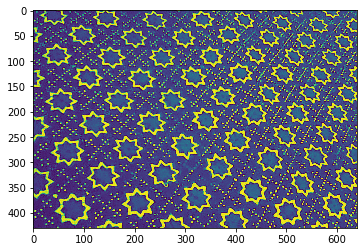

In [10]:
#### Main

# Defining paths
root_path = './'
training_folder_path = root_path + 'training/'
validation_folder_path = root_path + 'validation/'
test_folder_path = root_path + 'test/'

# Defining img type
img_type = '*.jpg'

# Initializing
initialize_model()
class_names = get_class_names(training_folder_path)
add_classes_to_model(class_names)

# Training
sampling_count = 128
glcm_angle = 0
glcm_distance = 1
train(training_folder_path, img_type, sampling_count, glcm_angle, glcm_distance)

# Validating
validate(validation_folder_path, img_type, sampling_count, glcm_angle, glcm_distance)

# Testing
test_img_path = test_folder_path + 'cap2.jpg'
test_img = load_img(test_img_path)
test_img_class = get_img_class(test_img, sampling_count, glcm_angle, glcm_distance)
print('This image is categorized as batik ' + test_img_class + '.')
print_img(test_img)

In [12]:
print(simplified_model['cap'])
print(simplified_model['tulis'])

(1.7857142857142856, 0.22386788051627896, 0.1737882653061225, 0.6824404761904761)
(1.1964285714285714, 0.3756386223169523, 0.17920918367346944, 0.7321428571428571)


This image is categorized as batik tulis.


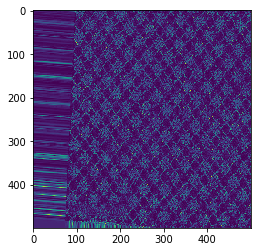

In [13]:
test_img_path = test_folder_path + 'tulis.jpg'
test_img = load_img(test_img_path)
test_img_class = get_img_class(test_img, sampling_count, glcm_angle, glcm_distance)
print('This image is categorized as batik ' + test_img_class + '.')
print_img(test_img)